In [521]:
#!pip install plotly_express
#!pip install IPython

In [478]:
%run algoritmo_evolutivo.ipynb

from sklearn.metrics import mean_squared_error as mse, r2_score
from sklearn.model_selection import train_test_split

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.animation as animation
import seaborn as sns

import plotly_express as px
import plotly.io as pio


## Reading the data

In [493]:
emissions_df = pd.read_csv("Fuel_Consumption_Ratings.csv", encoding='cp1252',
                 nrows=26082, usecols=[1,2,3,4,5,6,7,8,9,10,11,12,13,14], index_col=False)

emissions_df = emissions_df[['Engine_Size','Cylinders','Fuel_Consumption_City','Fuel_Consumption_Hwy','Fuel_Consumption_Comb','CO2_Emissions','CO2_Rating','Smog_Rating']]

# take a look at the dataset
emissions_df.sample(4)

,Engine_Size,Cylinders,Fuel_Consumption_City,Fuel_Consumption_Hwy,Fuel_Consumption_Comb,CO2_Emissions,CO2_Rating,Smog_Rating
1996,6.2,8,16.7,11.1,14.2,333,3.0,3.0
19737,2.5,6,13.1,9.1,11.3,260,NaN,NaN
7843,2.5,4,8.8,6.1,7.6,175,NaN,NaN
4293,5.3,8,13.4,10.0,11.8,278,4.0,3.0


## Separate features and target in different datasets

In [547]:
X =  emissions_df[['Engine_Size','Cylinders','Fuel_Consumption_City','Fuel_Consumption_Hwy']]
y =  emissions_df['CO2_Emissions']

X,X_test,y,y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [548]:
np.shape(y)

(20865,)

# Crear población

In [549]:
poblacion = Poblacion(
                n_individuos = 50,
                n_variables  = 5,
                limites_inf  = [-200,-200,-200,-200,-200],
                limites_sup  = [300,300,300,300,300],
                verbose = False
            )

In [550]:
#poblacion.mostrar_individuos(n=3)

# Evaluar población

In [551]:
def y_predict(a,b,c,d,e):
  return  a + b*X['Engine_Size'] + c*X['Cylinders'] + d*X['Fuel_Consumption_City'] +  e*X['Fuel_Consumption_Hwy'] 

def y_predict_test(a,b,c,d,e):
  return  a + b*X_test['Engine_Size'] + c*X_test['Cylinders'] + d*X_test['Fuel_Consumption_City'] +  e*X_test['Fuel_Consumption_Hwy'] 

In [552]:
# Seleccion aleatoria del punto de partida
p = np.random.rand(5) * 95 

y_pred = y_predict(p[0], p[1], p[2], p[3], p[4])
y_pred

26000    1633.695679
18035    1765.689431
19519    1920.113744
11326    3267.629806
24171    2109.982329
            ...     
21575    1849.721199
5390     2453.743354
860      1590.250848
15795    2416.106821
23654    2187.837684
Length: 20865, dtype: float64

In [553]:
def funcion_objetivo(a,b,c,d,e):
    f = sum(np.power( y - y_predict(a,b,c,d,e), 2)) * (1/len(y))
    return(f)

In [554]:
funcion_objetivo(p[0],p[1],p[2],p[3],p[4])

3343467.1437395583

In [560]:
poblacion.optimizar(
    funcion_objetivo   = funcion_objetivo,
    optimizacion       = "minimizar",
    n_generaciones     = 600,
    metodo_seleccion   = "rank",
    elitismo           = 0.2,
    prob_mut           = 0.1,
    distribucion       = "uniforme",
    media_distribucion = 1,
    sd_distribucion    = 1,
    min_distribucion   = -1,
    max_distribucion   = 1,
    parada_temprana    = True,
    rondas_parada      = 10,
    tolerancia_parada  = 10**-18,
    verbose            = False
)

Algoritmo detenido en la generación 536 por falta cambio absoluto mínimo de 1e-18 durante 10 generaciones consecutivas.


In [561]:
%matplotlib inline

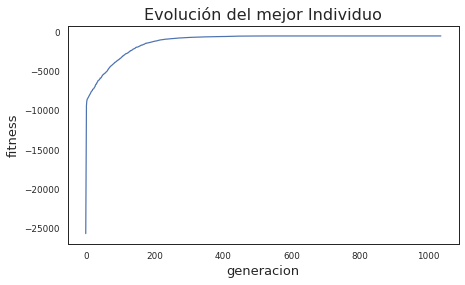

In [563]:
# Evolución de la optimización
fig, ax = plt.subplots(figsize=(7, 4))
poblacion.resultados_df.plot(x = "generacion",
                             y = "mejor_fitness",
                             ax= ax)
ax.set(title='Evolución del mejor Individuo', xlabel='generacion', ylabel='fitness')
ax.legend().set_visible(False)

****************************************************************
MSE: 22.13176243260279
R2-score: 0.89


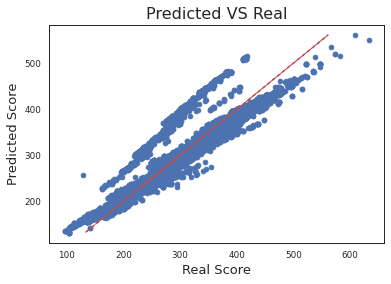

In [564]:
a,b,c,d,e = poblacion.valor_variables_optimo
prediction = y_predict(a,b,c,d,e)
print('*'*64)
print('MSE:', mse(y, prediction,squared=False))
print("R2-score: %.2f" % r2_score(y, prediction))
#print('intecep:',stimator.intercept_,' Coeficient:',stimator.coef_)

plt.ylabel('Predicted Score')
plt.xlabel('Real Score')
plt.title('Predicted VS Real')
plt.scatter(y, prediction)
plt.plot(prediction, prediction,'r--')
plt.show()

In [565]:
poblacion.valor_variables_optimo

array([43.2180654752191, 6.01663911748592, 4.282004273597799,
       7.321396414176406, 8.571019366091054], dtype=object)

In [582]:
def extraer_posicion(individuo):
    posicion = individuo.valor_variables
    return(posicion)

lista_df_temp = []

for i in np.arange(len(poblacion.historico_individuos)):
    posiciones = list(map(extraer_posicion, poblacion.historico_individuos[i]))
    df_temp = pd.DataFrame({"generacion": i, "posicion": posiciones})
    lista_df_temp.append(df_temp)

df_posiciones = pd.concat(lista_df_temp)

df_posiciones[['x_0','x_1','x_2','x_3','x_4']] = pd.DataFrame(df_posiciones["posicion"].values.tolist(),
                                            index= df_posiciones.index)

df_posiciones.head()

,generacion,posicion,x_0,x_1,x_2,x_3,x_4
0,0,"[-73.31902502070203, -115.98981248054601, 8.02...",-73.319025,-115.989812,8.028355,12.488238,103.529274
1,0,"[48.40484438005777, -117.61523038804232, -176....",48.404844,-117.615230,-176.689464,62.386099,181.928342
2,0,"[263.4469506562931, 219.81916201881, -48.62359...",263.446951,219.819162,-48.623598,232.836622,33.695772
3,0,"[-58.7764854438214, -153.92063594152043, 21.35...",-58.776485,-153.920636,21.356208,72.480680,-60.350315
4,0,"[-102.35058769320486, 270.4452340384322, -166....",-102.350588,270.445234,-166.112541,269.696128,3.206479


In [619]:
pio.renderers.default = 'colab'

px.scatter(
    df_posiciones,
    x       = "x_1",
    y       = "x_2",
    labels  = {"x_1": "", "x_2": ""},
    #range_x = [-200, 300],
    #range_y = [-200, 300],
    animation_frame = "generacion",
    width   = 700,
    height  = 700).update_xaxes(showgrid=True ).update_yaxes(
        showgrid=True)

# Another Analysis

### Valor óptimo de las variables: 43.2180654752191, 6.01663911748592, 4.282004273597799,7.321396414176406, 8.571019366091054

### Curvas de optimización 
Parametros (b,c) de:  
f(X) = a + b*X['Engine_Size'] + c*X['Cylinders'] + d*X['Fuel_Consumption_City'] +  e*X['Fuel_Consumption_Hwy']

In [600]:
z_1 = []
# Grid de datos
x_ = np.arange(-500, 700, 15)
y_ = np.arange(-400, 450, 15)
x_, y_ = np.meshgrid(x_, y_)
for xi, yi in zip(np.ravel(x_), np.ravel(y_)):
    z_1.append(funcion_objetivo(a=43.218,b=xi,c=yi,d=7.321,e=8.571))

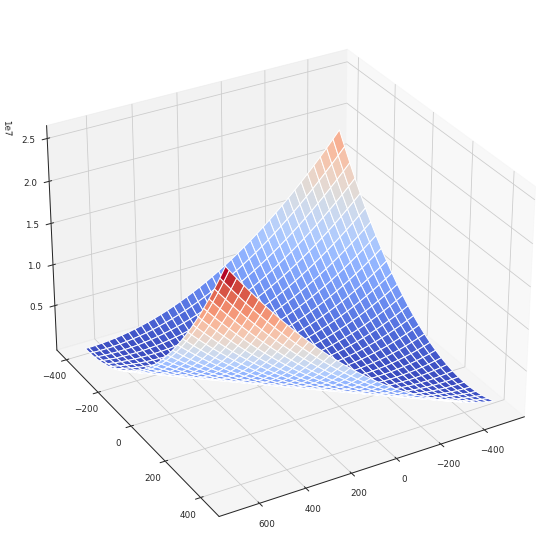

In [601]:
%matplotlib inline

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

z = np.array(z_1)
z = z.reshape(x_.shape)
grafico = ax.plot_surface(x_, y_, z, cmap=cm.coolwarm,
                       linewidth=1, antialiased=True)
ax.view_init(30, 60)

### Curvas de optimización 
Parametros (d,e) de:  
f(X) = a + b*X['Engine_Size'] + c*X['Cylinders'] + d*X['Fuel_Consumption_City'] +  e*X['Fuel_Consumption_Hwy']

In [603]:
z_2 = []
# Grid de datos
x_ = np.arange(-500, 700, 15)
y_ = np.arange(-400, 450, 15)
x_, y_ = np.meshgrid(x_, y_)
for xi, yi in zip(np.ravel(x_), np.ravel(y_)):
    z_2.append(funcion_objetivo(a=43.218,b=6.017,c=4.282,d=xi,e=yi))

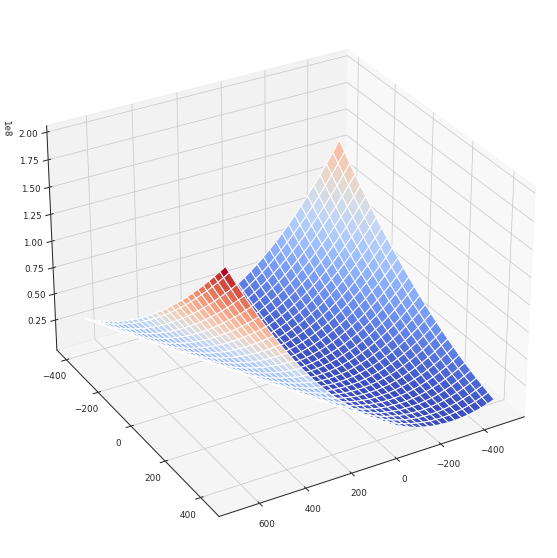

In [604]:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

z = np.array(z_2)
z = z.reshape(x_.shape)
grafico = ax.plot_surface(x_, y_, z, cmap=cm.coolwarm,
                       linewidth=1, antialiased=True)
ax.view_init(30, 60)

### Contorno parametros [b,c]

In [605]:
z_4 = []
x_0 = np.linspace(start = -500, stop = 700, num = 100)
x_1 = np.linspace(start = -400, stop = 450, num = 100)
x_0, x_1 = np.meshgrid(x_0, x_1)
for xi, yi in zip(np.ravel(x_0), np.ravel(x_1)):
        z_4.append(funcion_objetivo(a=43.218,b=xi,c=yi,d=7.321,e=8.571))
z_4 = np.array(z_4)
z_4 = z_4.reshape(x_0.shape)

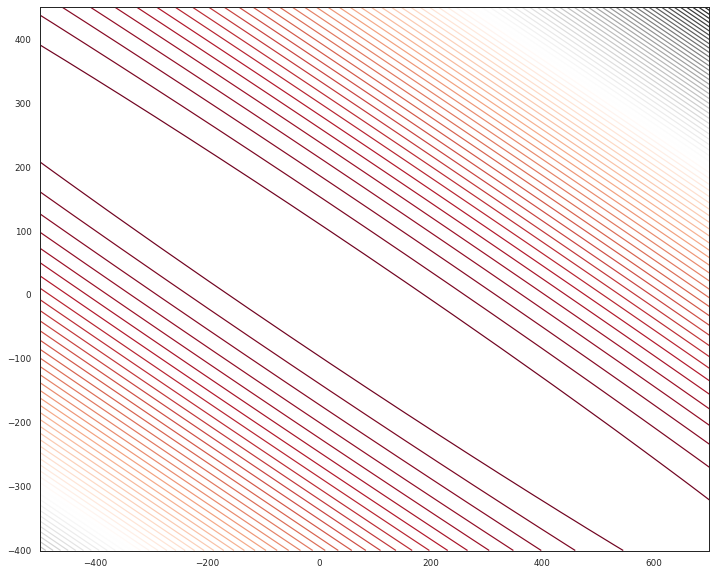

In [606]:
%matplotlib inline
fig = plt.figure(figsize=(12, 10))
plt.contour(x_0, x_1, z_4, 70, cmap='RdGy')

In [607]:
%matplotlib notebook
fig = plt.figure(figsize=(12, 10))
plt.xlim(-500,700)
plt.ylim(-400,450)

def animate(i):
    p2 = fig.clear()
    plt.xlim(-500,700)
    plt.ylim(-400,450)
    df_posiciones_i = df_posiciones[df_posiciones["generacion"] == i][["x_1", "x_2"]]
    p1 = plt.contour(x_0, x_1, z_3, 70, cmap='RdGy')
    p2 = plt.scatter(df_posiciones_i["x_1"], df_posiciones_i["x_2"])
    
ani = matplotlib.animation.FuncAnimation(fig, animate, frames=25, blit = True)

# Guardar la animación como mp4
Writer = animation.writers['ffmpeg']
writer = Writer(fps=2, bitrate=1800)
ani.save("dataframes/parameters_1.mp4", writer=writer)

<IPython.core.display.Javascript object>

### Contorno parametros [d,e]

In [612]:
z_3 = []
x_0 = np.linspace(start = -500, stop = 700, num = 100)
x_1 = np.linspace(start = -400, stop = 450, num = 100)
x_0, x_1 = np.meshgrid(x_0, x_1)
for xi, yi in zip(np.ravel(x_0), np.ravel(x_1)):
    z_3.append(funcion_objetivo(a=43.218,b=6.017,c=4.282,d=xi,e=yi))
z_3 = np.array(z_3)
z_3 = z_3.reshape(x_0.shape)

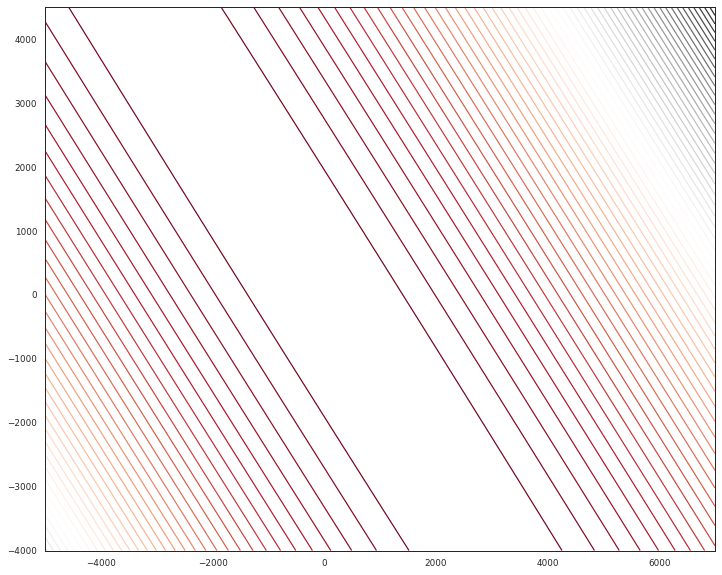

In [611]:
%matplotlib inline

fig = plt.figure(figsize=(12, 10))
plt.contour(x_0, x_1, z_3, 70, cmap='RdGy')

In [613]:
%matplotlib notebook
fig = plt.figure(figsize=(12, 10))
plt.xlim(-500,700)
plt.ylim(-400,450)

def animate(i):
    p2 = fig.clear()
    plt.xlim(-500,700)
    plt.ylim(-400,450)
    df_posiciones_i = df_posiciones[df_posiciones["generacion"] == i][["x_3", "x_4"]]
    p1 = plt.contour(x_0, x_1, z_3, 70, cmap='RdGy')
    p2 = plt.scatter(df_posiciones_i["x_3"], df_posiciones_i["x_4"])
    
ani = matplotlib.animation.FuncAnimation(fig, animate, frames=25, blit = True)

# Guardar la animación como mp4
Writer = animation.writers['ffmpeg']
writer = Writer(fps=2, bitrate=1800)
ani.save("dataframes/parameters_2.mp4", writer=writer)

<IPython.core.display.Javascript object>

In [614]:
%matplotlib inline

# Variando Individuos

In [480]:
num_individuos = [20, 30, 40, 50, 60, 70, 80]
time = []
RMSE_train = []
RMSE_test = []
r2_train = []
r2_test = []
poblacion_inicial = []

for i in num_individuos:
    
    time_aux = []
    RMSE_train_aux = []
    RMSE_test_aux = []
    r2_train_aux = []
    r2_test_aux = []
    
    print('Processing with:', i, 'Individuos')
    
    for j in range(1,3):
        poblacion = Poblacion(
            n_individuos = i,
            n_variables  = 5,
            limites_inf  = [-200,-200,-200,-200,-200],
            limites_sup  = [300,300,300,300,300],
            verbose = False
            )
        
        random.seed(123)
        poblacion.optimizar(
            funcion_objetivo   = funcion_objetivo,
            optimizacion       = "minimizar",
            n_generaciones     = 400,
            metodo_seleccion   = "rank",
            elitismo           = 0.1,
            prob_mut           = 0.1,
            distribucion       = "uniforme",
            media_distribucion = 1,
            sd_distribucion    = 1,
            min_distribucion   = -1,
            max_distribucion   = 1,
            parada_temprana    = True,
            rondas_parada      = 10,
            tolerancia_parada  = 10**-20,
            verbose            = False)
        
        a,b,c,d,e = poblacion.valor_variables_optimo                
        prediction_train = y_predict(a,b,c,d,e)
        prediction_test = y_predict_test(a,b,c,d,e)
                
            
        time_aux.append(round(poblacion.duration,3))
        RMSE_train_aux.append(round( mse(y,prediction_train,squared=False) ))
        RMSE_test_aux.append(round(mse(y_test,prediction_test,squared=False)))
        r2_train_aux.append(round(r2_score(y, prediction_train),3))
        r2_test_aux.append(round(r2_score(y_test, prediction_test),3))
        
    poblacion_inicial.append(i)
    time.append(np.mean(time_aux))
    RMSE_train.append(np.mean(RMSE_train_aux))
    RMSE_test.append(np.mean(RMSE_test_aux))
    r2_train.append(np.mean(r2_train_aux))
    r2_test.append(np.mean(r2_test_aux))

Processing with: 20 Individuos
Algoritmo detenido en la generación 305 por falta cambio absoluto mínimo de 1e-20 durante 10 generaciones consecutivas.
Processing with: 30 Individuos
Algoritmo detenido en la generación 305 por falta cambio absoluto mínimo de 1e-20 durante 10 generaciones consecutivas.
Processing with: 40 Individuos
Algoritmo detenido en la generación 336 por falta cambio absoluto mínimo de 1e-20 durante 10 generaciones consecutivas.
Processing with: 50 Individuos
Processing with: 60 Individuos
Algoritmo detenido en la generación 218 por falta cambio absoluto mínimo de 1e-20 durante 10 generaciones consecutivas.
Algoritmo detenido en la generación 279 por falta cambio absoluto mínimo de 1e-20 durante 10 generaciones consecutivas.
Processing with: 70 Individuos
Algoritmo detenido en la generación 360 por falta cambio absoluto mínimo de 1e-20 durante 10 generaciones consecutivas.
Algoritmo detenido en la generación 186 por falta cambio absoluto mínimo de 1e-20 durante 10 g

In [140]:
df = pd.DataFrame()
df['poblacion_inicial'] = poblacion_inicial
df['exec_time'] = time
df['RMSE_train'] = RMSE_train
df['RMSE_test'] = RMSE_test
df['r^2_train'] = r2_train
df['r^2_test'] = r2_test

print(df)

   poblacion_inicial  exec_time  RMSE_train  RMSE_test  r^2_train  r^2_test
0                 20     7.8070        34.0       33.0     0.6570    0.6715
1                 30    11.6680        16.5       15.5     0.9345    0.9450
2                 40    12.0275        15.5       14.5     0.9405    0.9490
3                 50    18.2025        19.0       18.0     0.9085    0.9190
4                 60    19.3335        15.0       14.5     0.9440    0.9505
5                 70    25.7555        22.0       21.5     0.8830    0.8930
6                 80    29.4165        20.5       20.0     0.8970    0.9045


In [141]:
df.to_csv('dataframes/poblacion.csv', index=False)
df_poblacion = pd.read_csv("dataframes/poblacion.csv", encoding='cp1252', index_col=False)
df_poblacion

,poblacion_inicial,exec_time,RMSE_train,RMSE_test,r^2_train,r^2_test
0,20,7.8070,34.0,33.0,0.6570,0.6715
1,30,11.6680,16.5,15.5,0.9345,0.9450
2,40,12.0275,15.5,14.5,0.9405,0.9490
3,50,18.2025,19.0,18.0,0.9085,0.9190
4,60,19.3335,15.0,14.5,0.9440,0.9505
5,70,25.7555,22.0,21.5,0.8830,0.8930
6,80,29.4165,20.5,20.0,0.8970,0.9045


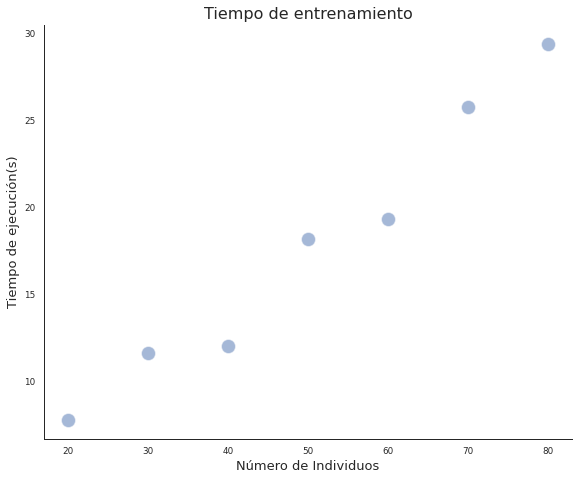

In [142]:
sns.set_theme(style="white")
sns.set_context("paper", rc={"font.size":20,"axes.titlesize":16,"axes.labelsize":13})   


sns.relplot(x="poblacion_inicial", y="exec_time", alpha=.5, palette="muted", s=200,
            height=6, data=df_poblacion) \
    .set(title='Tiempo de entrenamiento', xlabel='Número de Individuos', ylabel='Tiempo de ejecución(s)',
        )
plt.gcf().set_size_inches(9, 7)

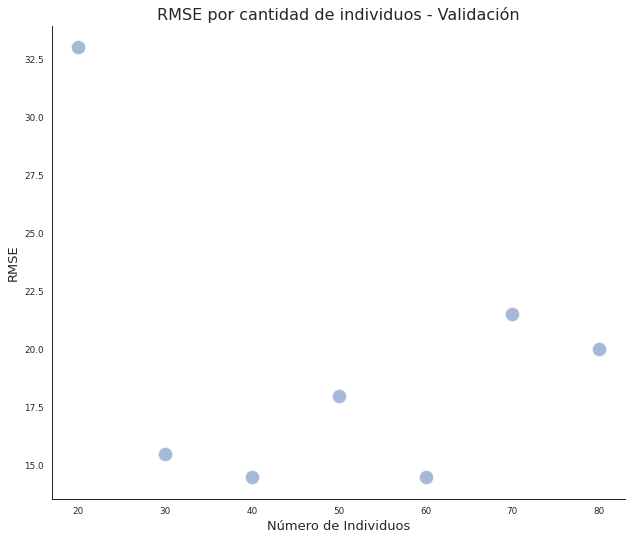

In [143]:
sns.set_theme(style="white")
sns.set_context("paper", rc={"font.size":20,"axes.titlesize":16,"axes.labelsize":13})   


sns.relplot(x="poblacion_inicial", y="RMSE_test", alpha=.5, palette="muted", s=200,
            height=6, data=df_poblacion) \
    .set(title='RMSE por cantidad de individuos - Validación', xlabel='Número de Individuos', ylabel='RMSE')
plt.gcf().set_size_inches(10, 8)

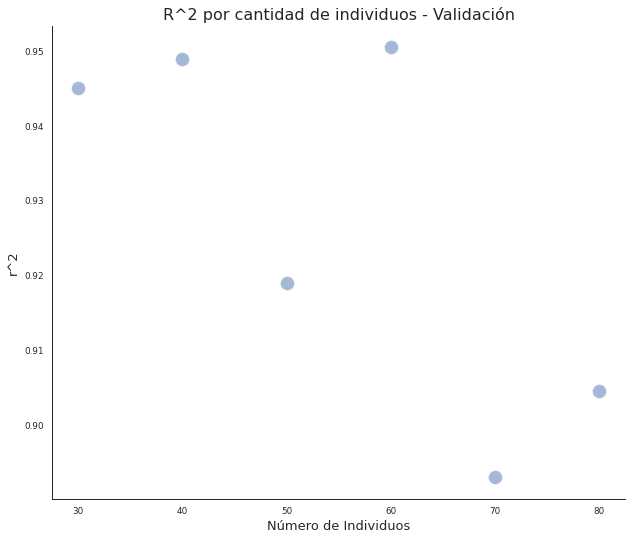

In [144]:
sns.set_theme(style="white")
sns.set_context("paper", rc={"font.size":20,"axes.titlesize":16,"axes.labelsize":13})   


sns.relplot(x="poblacion_inicial", y="r^2_test", alpha=.5, palette="muted", s=200,
            height=6, data=df_poblacion.iloc[1:]) \
    .set(title='R^2 por cantidad de individuos - Validación', xlabel='Número de Individuos', ylabel='r^2')
plt.gcf().set_size_inches(10, 8)

# Variando Metodo de selección

In [70]:
metodo = ["ruleta", "rank", "tournament"]

time = []
RMSE_train = []
RMSE_test = []
r2_train = []
r2_test = []
metodo_seleccion = []

for i in metodo:
    
    time_aux = []
    RMSE_train_aux = []
    RMSE_test_aux = []
    r2_train_aux = []
    r2_test_aux = []
    
    print('Processing with:', i, 'Individuos')
    
    for j in range(1,6):
        
        poblacion = Poblacion(
            n_individuos = 100,
            n_variables  = 5,
            #limites_inf  = [0,-10,-10,-10,-10],
            #limites_sup  = [100,-50,50,50,50],
            verbose = False
            )
        
        poblacion.optimizar(
            funcion_objetivo   = funcion_objetivo,
            optimizacion       = "minimizar",
            n_generaciones     = 1200,
            metodo_seleccion   = i,
            elitismo           = 0.2,
            prob_mut           = 0.1,
            distribucion       = "uniforme",
            media_distribucion = 1,
            sd_distribucion    = 1,
            min_distribucion   = -1,
            max_distribucion   = 1,
            parada_temprana    = True,
            rondas_parada      = 10,
            tolerancia_parada  = 10**-20,
            verbose            = False)
        
        a,b,c,d,e = poblacion.valor_variables_optimo                
        prediction_train = y_predict(a,b,c,d,e)
        prediction_test = y_predict_test(a,b,c,d,e)
                
            
        time_aux.append(round(poblacion.duration,3))
        RMSE_train_aux.append(round( mse(y,prediction_train,squared=False) ))
        RMSE_test_aux.append(round(mse(y_test,prediction_test,squared=False)))
        r2_train_aux.append(round(r2_score(y, prediction_train),3))
        r2_test_aux.append(round(r2_score(y_test, prediction_test),3))
        
    metodo_seleccion.append(i)
    time.append(np.mean(time_aux))
    RMSE_train.append(np.mean(RMSE_train_aux))
    RMSE_test.append(np.mean(RMSE_test_aux))
    r2_train.append(np.mean(r2_train_aux))
    r2_test.append(np.mean(r2_test_aux))

Processing with: ruleta Individuos
Algoritmo detenido en la generación 11 por falta cambio absoluto mínimo de 1e-20 durante 10 generaciones consecutivas.
Algoritmo detenido en la generación 11 por falta cambio absoluto mínimo de 1e-20 durante 10 generaciones consecutivas.
Algoritmo detenido en la generación 11 por falta cambio absoluto mínimo de 1e-20 durante 10 generaciones consecutivas.
Algoritmo detenido en la generación 11 por falta cambio absoluto mínimo de 1e-20 durante 10 generaciones consecutivas.
Algoritmo detenido en la generación 11 por falta cambio absoluto mínimo de 1e-20 durante 10 generaciones consecutivas.
Processing with: rank Individuos
Algoritmo detenido en la generación 767 por falta cambio absoluto mínimo de 1e-20 durante 10 generaciones consecutivas.
Algoritmo detenido en la generación 1133 por falta cambio absoluto mínimo de 1e-20 durante 10 generaciones consecutivas.
Algoritmo detenido en la generación 757 por falta cambio absoluto mínimo de 1e-20 durante 10 gen

In [71]:
df = pd.DataFrame()
df['metodo_seleccion'] = metodo_seleccion
df['exec_time'] = time
df['RMSE_train'] = RMSE_train
df['RMSE_test'] = RMSE_test
df['r^2_train'] = r2_train
df['r^2_test'] = r2_test

print(df)

  metodo_seleccion  exec_time  RMSE_train  RMSE_test  r^2_train  r^2_test
0           ruleta     1.2132       610.6      595.4   -93.8120  -86.5476
1             rank    94.8370        15.2       14.8     0.9432    0.9500
2       tournament   112.0012        19.0       17.8     0.8990    0.9146


In [72]:
df.to_csv('dataframes/metodo_seleccion.csv', index=False)
df_mtd_seleccion = pd.read_csv("dataframes/metodo_seleccion.csv", encoding='cp1252', index_col=False)
df_mtd_seleccion

,metodo_seleccion,exec_time,RMSE_train,RMSE_test,r^2_train,r^2_test
0,ruleta,1.2132,610.6,595.4,-93.8120,-86.5476
1,rank,94.8370,15.2,14.8,0.9432,0.9500
2,tournament,112.0012,19.0,17.8,0.8990,0.9146


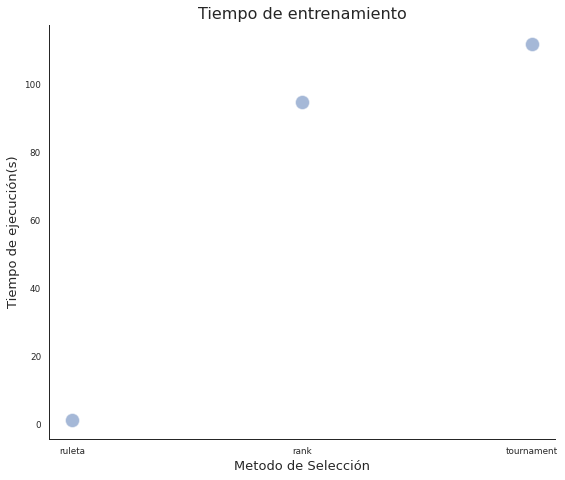

In [81]:
sns.set_theme(style="white")
sns.set_context("paper", rc={"font.size":20,"axes.titlesize":16,"axes.labelsize":13})   


sns.relplot(x="metodo_seleccion", y="exec_time", alpha=.5, palette="muted", s=200,
            height=6, data=df_mtd_seleccion) \
    .set(title='Tiempo de entrenamiento', xlabel='Metodo de Selección', ylabel='Tiempo de ejecución(s)',
        )
plt.gcf().set_size_inches(9, 7)

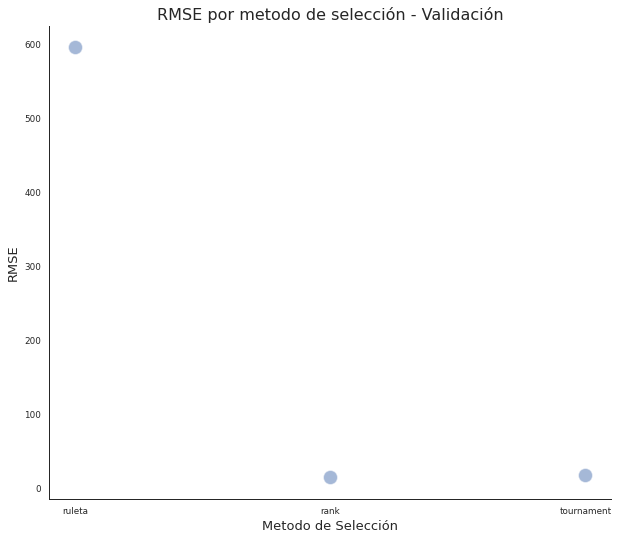

In [80]:
sns.set_theme(style="white")
sns.set_context("paper", rc={"font.size":20,"axes.titlesize":16,"axes.labelsize":13})   


sns.relplot(x="metodo_seleccion", y="RMSE_test", alpha=.5, palette="muted", s=200,
            height=6, data=df_mtd_seleccion) \
    .set(title='RMSE por metodo de selección - Validación', xlabel='Metodo de Selección', ylabel='RMSE')
plt.gcf().set_size_inches(10, 8)

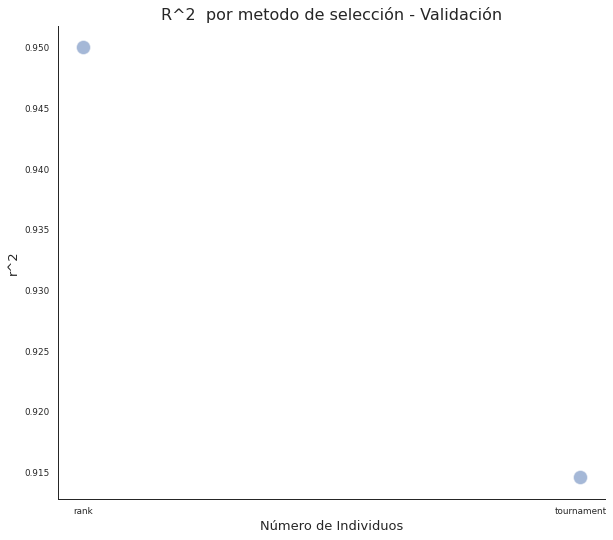

In [79]:
sns.set_theme(style="white")
sns.set_context("paper", rc={"font.size":20,"axes.titlesize":16,"axes.labelsize":13})   


sns.relplot(x="metodo_seleccion", y="r^2_test", alpha=.5, palette="muted", s=200,
            height=6, data=df_mtd_seleccion.iloc[1:]) \
    .set(title='R^2  por metodo de selección - Validación', xlabel='Metodo de Selección', ylabel='r^2')
plt.gcf().set_size_inches(10, 8)

# Mutación

In [94]:
mutaciones = [0.2, 0.1, 0.05, 0.025, 0.01]

time = []
RMSE_train = []
RMSE_test = []
r2_train = []
r2_test = []
prob_mutacion = []

for i in mutaciones:
    
    time_aux = []
    RMSE_train_aux = []
    RMSE_test_aux = []
    r2_train_aux = []
    r2_test_aux = []
    
    print('Processing with:', i, 'Individuos')
    
    for j in range(1,4):
        
        poblacion = Poblacion(
            n_individuos = 100,
            n_variables  = 5,
            #limites_inf  = [0,-10,-10,-10,-10],
            #limites_sup  = [100,-50,50,50,50],
            verbose = False
            )
        
        poblacion.optimizar(
            funcion_objetivo   = funcion_objetivo,
            optimizacion       = "minimizar",
            n_generaciones     = 1000,
            metodo_seleccion   = 'rank',
            elitismo           = 0.2,
            prob_mut           = i,
            distribucion       = "uniforme",
            media_distribucion = 1,
            sd_distribucion    = 1,
            min_distribucion   = -1,
            max_distribucion   = 1,
            parada_temprana    = True,
            rondas_parada      = 10,
            tolerancia_parada  = 10**-20,
            verbose            = False)
        
        a,b,c,d,e = poblacion.valor_variables_optimo                
        prediction_train = y_predict(a,b,c,d,e)
        prediction_test = y_predict_test(a,b,c,d,e)
                
            
        time_aux.append(round(poblacion.duration,3))
        RMSE_train_aux.append(round( mse(y,prediction_train,squared=False) ))
        RMSE_test_aux.append(round(mse(y_test,prediction_test,squared=False)))
        r2_train_aux.append(round(r2_score(y, prediction_train),3))
        r2_test_aux.append(round(r2_score(y_test, prediction_test),3))
        
    prob_mutacion.append(i)
    time.append(np.mean(time_aux))
    RMSE_train.append(np.mean(RMSE_train_aux))
    RMSE_test.append(np.mean(RMSE_test_aux))
    r2_train.append(np.mean(r2_train_aux))
    r2_test.append(np.mean(r2_test_aux))

Processing with: 0.2 Individuos
Algoritmo detenido en la generación 967 por falta cambio absoluto mínimo de 1e-20 durante 10 generaciones consecutivas.
Algoritmo detenido en la generación 805 por falta cambio absoluto mínimo de 1e-20 durante 10 generaciones consecutivas.
Algoritmo detenido en la generación 1123 por falta cambio absoluto mínimo de 1e-20 durante 10 generaciones consecutivas.
Processing with: 0.1 Individuos
Algoritmo detenido en la generación 1127 por falta cambio absoluto mínimo de 1e-20 durante 10 generaciones consecutivas.
Algoritmo detenido en la generación 1185 por falta cambio absoluto mínimo de 1e-20 durante 10 generaciones consecutivas.
Processing with: 0.05 Individuos
Algoritmo detenido en la generación 805 por falta cambio absoluto mínimo de 1e-20 durante 10 generaciones consecutivas.
Algoritmo detenido en la generación 967 por falta cambio absoluto mínimo de 1e-20 durante 10 generaciones consecutivas.
Processing with: 0.025 Individuos
Algoritmo detenido en la g

In [95]:
df = pd.DataFrame()
df['Probabilidad de mutacion'] = prob_mutacion
df['exec_time'] = time
df['RMSE_train'] = RMSE_train
df['RMSE_test'] = RMSE_test
df['r^2_train'] = r2_train
df['r^2_test'] = r2_test


In [96]:
df.to_csv('dataframes/mutacion.csv', index=False)
df_mutacion = pd.read_csv("dataframes/mutacion.csv", encoding='cp1252', index_col=False)
df_mutacion

,Probabilidad de mutacion,exec_time,RMSE_train,RMSE_test,r^2_train,r^2_test
0,0.200,96.677333,15.0,14.666667,0.944,0.951000
1,0.100,121.506667,23.0,21.333333,0.839,0.871333
2,0.050,106.191333,16.0,15.000000,0.938,0.947000
3,0.025,102.571333,15.0,14.333333,0.944,0.950333
4,0.010,121.629333,16.0,15.333333,0.937,0.944333


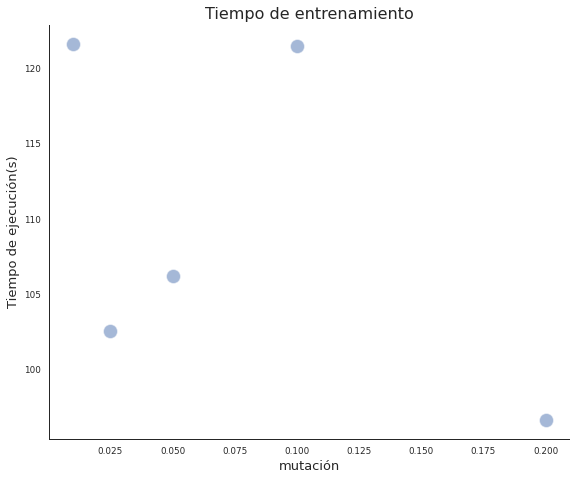

In [97]:
sns.set_theme(style="white")
sns.set_context("paper", rc={"font.size":20,"axes.titlesize":16,"axes.labelsize":13})   


sns.relplot(x="Probabilidad de mutacion", y="exec_time", alpha=.5, palette="muted", s=200,
            height=6, data=df_mutacion) \
    .set(title='Tiempo de entrenamiento', xlabel='mutación', ylabel='Tiempo de ejecución(s)',
        )
plt.gcf().set_size_inches(9, 7)

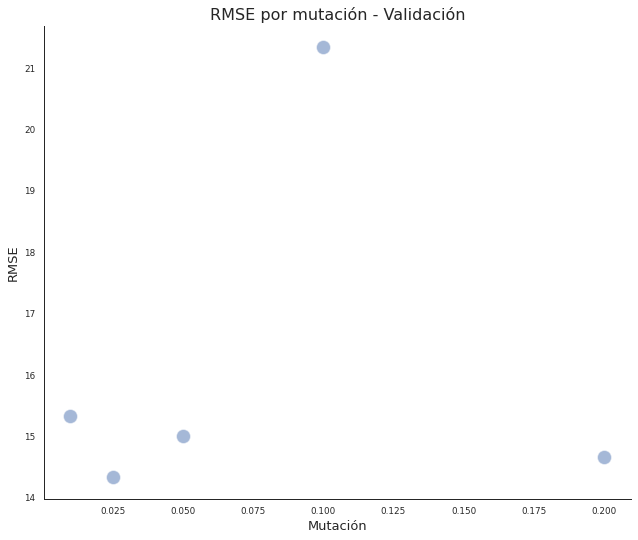

In [98]:
sns.set_theme(style="white")
sns.set_context("paper", rc={"font.size":20,"axes.titlesize":16,"axes.labelsize":13})   


sns.relplot(x="Probabilidad de mutacion", y="RMSE_test", alpha=.5, palette="muted", s=200,
            height=6, data=df_mutacion) \
    .set(title='RMSE por mutación - Validación', xlabel='Mutación', ylabel='RMSE')
plt.gcf().set_size_inches(10, 8)

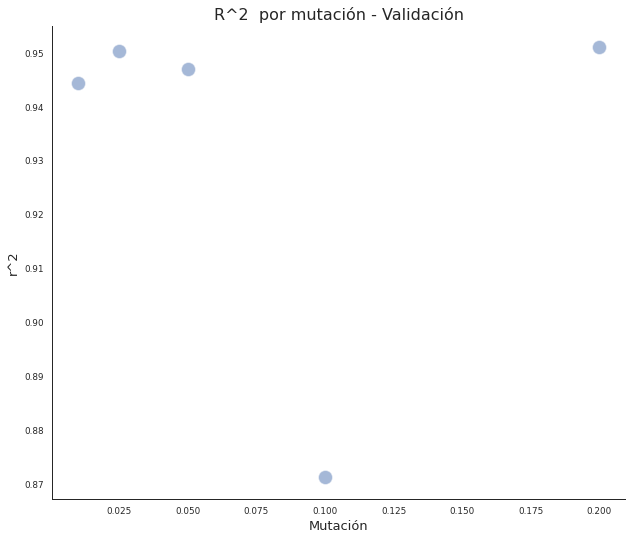

In [99]:
sns.set_theme(style="white")
sns.set_context("paper", rc={"font.size":20,"axes.titlesize":16,"axes.labelsize":13})   


sns.relplot(x="Probabilidad de mutacion", y="r^2_test", alpha=.5, palette="muted", s=200,
            height=6, data=df_mutacion) \
    .set(title='R^2  por mutación - Validación', xlabel='Mutación', ylabel='r^2')
plt.gcf().set_size_inches(10, 8)